In [1]:
%%capture
#!pip install wfdb
BASEPATH = '../'
import sys
sys.path.insert(0,'..')

import numpy as np
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
#tf.get_logger().setLevel('ERROR')
from pyecg.utils import reset_seed, plot_spectogram, plot_loss, load_data
from pyecg.utils import integer_mapping, mapping_AAMI
from pyecg.data_info import *
from pyecg.data_handling import DataHandling
from pyecg.data_preprocessing import DataPreprocessing
from pyecg.report import Reports
from pyecg.models.conv1D import model_arch 

reset_seed()

# Data

In [2]:
#Load Preprocessed data
x_train, y_train = load_data(file_path = '../data/DS1_train.dat')
#Load Preprocessed data
x_val, y_val = load_data(file_path = '../data/DS1_val.dat')
x_train.shape, len(y_train), x_val.shape, len(y_val)

File loaded: ../data/DS1_train.dat
File loaded: ../data/DS1_val.dat


((47109, 256), 47109, (3891, 256), 3891)

In [3]:
dh = DataHandling()
rp1 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp1

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,34721,3947,3780,16,16,3163,105,807,2,100,32,414,0,0,6
val,3366,0,0,0,0,520,0,3,0,0,0,0,0,0,2


In [4]:
y_train = mapping_AAMI(y_train, MAP_AAMI)
y_val = mapping_AAMI(y_val, MAP_AAMI)

In [5]:
rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,42480,0,0,0,0,3268,0,0,941,0,0,414,0,0,6
val,3366,0,0,0,0,520,0,0,3,0,0,0,0,0,2


In [6]:
INT_MAP_DICT = {'N':0,'V':1,'S':2,'F':3,'Q':4}
y_train = integer_mapping(y_train, INT_MAP_DICT)
y_val = integer_mapping(y_val, INT_MAP_DICT)

# Train

In [7]:
params = {
    'seq_len' : x_train.shape[1],
    'num_classes' : 5,
    'drate' : 0.50,
    'batch_size' : 128,
    'epochs' : 30
}

In [8]:
model_classifier  = model_arch(input_dim=params['seq_len'])                                          

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 254, 64], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")


KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 250, 64], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")


KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 242, 64], name='tf.compat.v1.shape_2/Shape:0', description="created by layer 'tf.compat.v1.shape_2'")


KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None), inferred_value=[None, 3840], name='tf.compat.v1.shape_3/Shape:0', description="created by layer 'tf.compat.v1.shape_3'")


In [34]:
#%%capture
#!pip install focal-loss
from focal_loss import SparseCategoricalFocalLoss

In [35]:
!rm -r /media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1

opt= tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam')
#opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.01)


#for loss try sample_weight
model_classifier.compile(
                      optimizer=opt,
                      loss=SparseCategoricalFocalLoss(gamma=3),
                      #loss="sparse_categorical_crossentropy",
                      metrics=['sparse_categorical_crossentropy','accuracy'],
                      loss_weights=None
                      )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.EXP1",
                                                      monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]  

rm: cannot remove '/media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1': No such file or directory


In [36]:
%%time

model_history = model_classifier.fit(
              x=x_train,
              y=y_train,
              batch_size=params['batch_size'],
              epochs=params['epochs'],
              verbose=1,
              #callbacks=callbacks,
              validation_data=(x_val, y_val),
              shuffle=True,
              class_weight=None,
              sample_weight=None,
              initial_epoch=0
              )

Epoch 1/30
369/369 [==============================] - 127s 340ms/step - loss: 0.1089 - sparse_categorical_crossentropy: 0.2915 - accuracy: 0.9462 - val_loss: 0.1055 - val_sparse_categorical_crossentropy: 0.3491 - val_accuracy: 0.8700
Epoch 2/30
369/369 [==============================] - 124s 337ms/step - loss: 0.0959 - sparse_categorical_crossentropy: 0.3444 - accuracy: 0.9468 - val_loss: 0.0875 - val_sparse_categorical_crossentropy: 0.4028 - val_accuracy: 0.8882
Epoch 3/30
369/369 [==============================] - 126s 342ms/step - loss: 0.0984 - sparse_categorical_crossentropy: 0.3678 - accuracy: 0.9450 - val_loss: 0.0851 - val_sparse_categorical_crossentropy: 0.4040 - val_accuracy: 0.8707
Epoch 4/30
 16/369 [>.............................] - ETA: 2:03 - loss: 0.0811 - sparse_categorical_crossentropy: 0.3388 - accuracy: 0.9492

KeyboardInterrupt: 

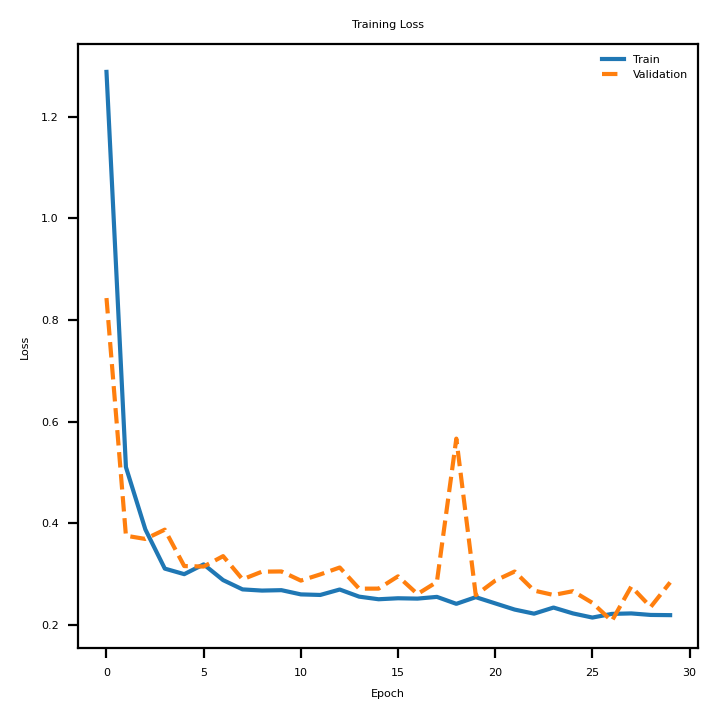

In [37]:
plot_loss(model_history)

In [38]:
import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)


In [39]:
a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

(0.2076679915189743, 26)

# Loading Model

In [40]:
#loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.EXP1')
loaded_model = model_classifier
loaded_model.name

'model'

In [41]:
#loaded_model.summary()

In [42]:
#Load Preprocessed Test Set
x_test, y_test = load_data(file_path = '../data/DS2.dat')
y_true = y_test.copy()
x_test.shape, len(y_test)

File loaded: ../data/DS2.dat


((49693, 256), 49693)

In [43]:
y_true = mapping_AAMI(y_true, MAP_AAMI)

In [44]:
%%time
y_pred_prob = loaded_model.predict(x_test)

CPU times: user 22.8 s, sys: 104 ms, total: 22.9 s
Wall time: 22.6 s


In [45]:
y_pred = integer_mapping(list(y_pred_prob.argmax(axis=-1)), INT_MAP_DICT, inverse=True)

In [46]:
dh = DataHandling()
rp2 = dh.report_stats_table([y_pred, y_true], ['y_pred','y_true'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
y_pred,47672,0,0,0,0,2021,0,0,0,0,0,0,0,0,0
y_true,44241,0,0,0,0,3220,0,0,1837,0,0,388,0,0,7


/home/mypc/anaconda3/envs/ecg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mypc/anaconda3/envs/ecg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mypc/anaconda3/envs/ecg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           F     0.0000    0.0000    0.0000       388
           N     0.9272    0.9991    0.9618     44241
           Q     0.0000    0.0000    0.0000         7
           S     0.0000    0.0000    0.0000      1837
           V     0.9555    0.5997    0.7369      3220

    accuracy                         0.9284     49693
   macro avg     0.3765    0.3198    0.3397     49693
weighted avg     0.8874    0.9284    0.9040     49693



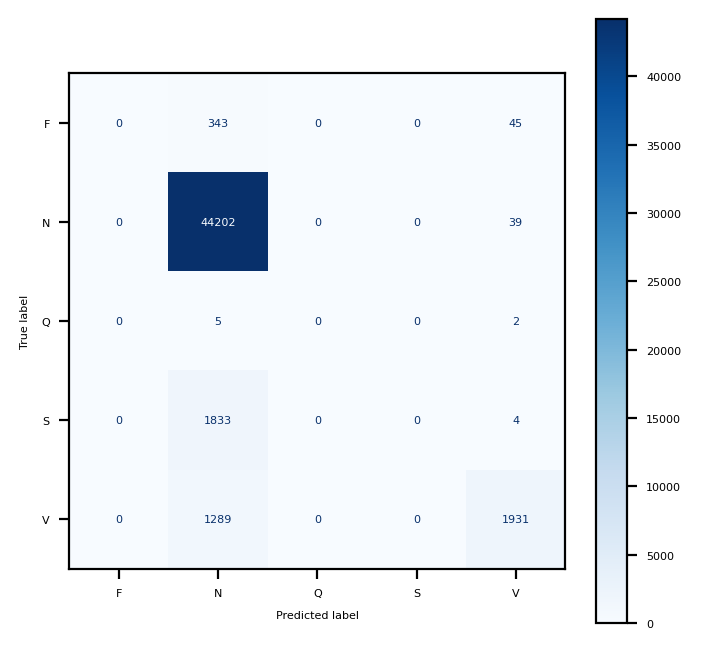

In [47]:
labels = [k for k,v in INT_MAP_DICT.items()]
report = Reports(y_true=y_true, y_pred=y_pred, labels=labels)
normalize = None
report.plot_confusion_matrix(normalize=normalize, values_format='')
print(report.the_classification_report())
#report.metrics_table()
